___

# Atividade - Regressão Linear Simples

## Aula 22
___

<div id="indice"></div>

## Índice

- [Renda vs CO2](#base)
    - [Dados: Inner Join](#join)
    - [Problema](#problema)
- [Ajustando um modelo de regressão simples via Mínimos Quadrados](#regressao)
    - [Suposições do modelo](#suposicoes)
    - [Exercício 1 - $\hat{\beta}_1$ e  $\hat{\beta}_0$](#ex1)
    - [Verificando os resultados da regressão](#verificando-resultados)
    - [Exercício 2 - Resíduos ](#ex2)
- [Ajustando um modelo de regressão simples via `statsmodels.OLS`](#ols)
    - [Teste de hipóteses para os coeficientes](#th-coefs)
    - [Usando `statsmodels.OLS`](#usando-ols)
    - [Exercício 3 - Plot da reta ajustada](#ex3)
    - [Exercício 4 - Resíduos](#ex4)
    - [Exercício 5](#ex5)
- [Explicação sobre resultados e suposições do modelo de regressão linear:](#explica)
    - [Teste t :  valor-*p*  da estatística t](#testet)
    - [Coeficiente de determinação $R^2$](#r2)
    - [$R^2$ ajustado](#r2adj)
    - [Estatística F](#f)
    - [Teste Omnibus](#omnibus)
    - [Teste Jarque-Bera](#jb)
    - [Teste Durbin-Watson](#dw)
- [Utilização dos resultados e validação das suposições do modelo:](#uso)    
    - [Exercício 6 - Análise dos valores p](#ex6)
    - [Exercício 7 - Análise da estatística F](#ex7)
    - [Exercício 8 - Análise do $R^2$](#ex8)
    - [Exercício 9 - Análise de normalidade do resíduo](#ex9)
    - [Exercício 10 - Análise de homocedasticidade](#ex10)
___

___

<div id="base"></div>

# Renda vs CO2

Vamos trabalhar com os seguintes dados coletados do site https://www.gapminder.org/:
1. Emissão de CO2 per capita
1. Renda per capita

As linhas representam os países e as colunas representam a emissão de CO2 ou renda per capita em cada ano. Estamos interessados em investigar a relação entre essas variáveis.

Como os arquivos estão separados, será preciso juntá-los cruzando o país.

In [2]:
%matplotlib inline
import pandas as pd

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
#Leitura dos arquivos em Excel
co2 = pd.read_excel('indicator CDIAC carbon_dioxide_emissions_per_capita.xlsx')
income = pd.read_excel('indicator gapminder gdp_per_capita_ppp.xlsx')

In [4]:
#É possível verificar que cada linha representa um país e as colunas representam o ano
co2.head(3)

,CO2 per capita,1751,1755,1762,1763,1764,1765,1766,1767,1768,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
0,Abkhazia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.022704,0.027472,0.03678,0.04709,0.068312,0.131602,0.213325,0.262174,NaN,NaN
2,Akrotiri and Dhekelia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#O mesmo se aplica a renda.
income.head(3)

,GDP per capita,1800,1801,1802,1803,1804,1805,1806,1807,1808,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,Abkhazia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,603.0,603.0,603.0,603.0,603.0,603.0,603.0,603.0,603.0,...,1173.0,1298.0,1311.0,1548.0,1637.0,1695.0,1893.0,1884.0,1877.0,1925.0
2,Akrotiri and Dhekelia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


___

<div id="join"></div>

### Dados: Inner Join

Vamos agora juntar as duas tabelas via país, selecionar apenas o ano de 2010 e remover os NaNs.

Ao final vamos fazer o gráfico de dispersão das duas variáveis.

**Sugestão**: pesquise sobre a função DataFrame.join(), pode ser muito útil no futuro.

In [6]:
#Cruza as duas tabelas via país
co2_index = co2.set_index('CO2 per capita')
income_index = income.set_index('GDP per capita')

df = co2_index.join(income_index, how='inner', lsuffix='_co2', rsuffix='_income')

In [7]:
#Seleciona o ano de 2010 e remove os NaNs
df = df[['2010_co2','2010_income']].dropna()
df.head()

,2010_co2,2010_income
Afghanistan,0.262174,1637.0
Albania,1.336544,9374.0
Algeria,3.480977,12494.0
Andorra,6.092100,38982.0
Angola,1.593918,7047.0


In [8]:
#Transforma a renda na escala de milhares de dólares
df['2010_income'] /= 1000
df.head()

,2010_co2,2010_income
Afghanistan,0.262174,1.637
Albania,1.336544,9.374
Algeria,3.480977,12.494
Andorra,6.092100,38.982
Angola,1.593918,7.047


___

<div id="problema"></div>

### Problema

Considere que o objetivo aqui seja **explicar/prever** a emissão de gás carbono (CO2) per capita de um país em função da renda (PIB) per capita.

Por conta disso, vamos considerar `CO2` como variável dependente (ou variável resposta ou variável *target*) para ser considerada no `eixo y` e `renda` como independente (ou explicativa ou *features*) no `eixo x`.

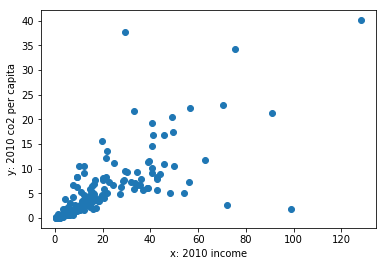

In [9]:
x_dados = df['2010_income'] # Definindo renda como explicativa
y_dados = df['2010_co2']    # Definindo CO2 como resposta

plt.scatter(x_dados,y_dados);
plt.xlabel("x: 2010 income");
plt.ylabel("y: 2010 co2 per capita");

___

<div id="regressao"></div>

# Ajustando um modelo de regressão simples via Mínimos Quadrados

Vamos tentar agora ajustar um modelo sobre os dados. A primeira tentativa será ajustar um reta:

$$y_i=\beta_0+\beta_1x_i+\varepsilon_i$$

Onde:
1. $\beta_i$ são os coeficientes do modelo de regressão;
1. $\varepsilon_i$ representa os **erros aleatórios**. O erro aleatório tem média zero e variância (desconhecida) $\sigma^2$. Além disso, esses erros aleatórios correspondentes as diferentes observações são também considerados variáveis aleatórias não correlacionadas. Vide Montegomery e Runger (2018), Seção 11-2, página 335.

O primeiro passo agora é calcular os valores da regressão. Existem diversas formas de estimar os $\beta$s, vamos utilizar o método de **Mínimos Quadrados Ordinários (MQO ou OLS - Ordinary Least Squares em inglês)**. 

$$\hat{\beta}_0=\bar{y}-\hat{\beta}_1\bar{x}$$

$$\hat{\beta}_1=\frac{S_{XY}}{S_{XX}}=\frac{\sum_{i=1}^n(x_i-\bar{x})(y_i-\bar{y})}{\sum_{i=1}^n(x_i-\bar{x})^2}$$

<div id="suposicoes"></div>

### Suposições do modelo

Para podermos aplicar o modelo é necessário fazermos algumas suposições:

1. Os **erros têm distribuição normal** com média 0 e variância constante, ou seja, $\varepsilon_i \sim N(0, \sigma^2)$.
2. Os **erros são independentes** entre si, ou seja, $Corr(\varepsilon_i, \varepsilon_j)=0$, para qualquer $i \neq j$.
3. **O modelo é linear nos parâmetros**.
4. **Homocedasticidade: $Var(\varepsilon_i) = \sigma^2$** para qualquer $i = 1, \dots, n$.

___

<div id="ex1"></div>

### EXERCÍCIO 1 - $\hat{\beta}_1$ e  $\hat{\beta}_0$

Calcule os valores de $\bar{x}$ e $\bar{y}$. Calcule também $S_{XX}$ e $S_{XY}$, em seguida calcule o $\hat{\beta}_1$ e o $\hat{\beta}_0$. Armazene os resultados de $\hat{\beta}_1$ e $\hat{\beta}_0$ nas variáveis `b1` e `b0`, respectivamente.

In [10]:
# ESCREVA SEU CÓDIGO AQUI

xbarra = x_dados.mean()
ybarra = y_dados.mean()

In [11]:
num = ((x_dados-xbarra)*(y_dados-ybarra)).sum()
den = ((x_dados-xbarra)**2).sum()

b1 = num/den
b0 = ybarra - beta1*xbarra

print("Coeficiente linear  (beta0): {}".format(b0))
print("Coeficiente angular (beta1): {}".format(b1))
print("Valor previsto para CO2 = {0:g} + {1:g}*Renda".format(b0, b1))

NameError: name 'beta1' is not defined

<div id="verificando-resultados"></div>

### Verificando os resultados da regressão

Vamos contrastar a reta estimada pelo modelo de regressão com os dados observados.

Para tanto, serão construídos:
 * `x_vec`: vetor de valores considerando a amplitude dos dados que estão no `eixo x`
 * `y_vec`: vetor com valores ajustados para y a partir de um valor de `x_vec`, considerando os coeficentes da reta

In [ ]:
x_vec = np.linspace(x_dados.min(), x_dados.max(), 500)
y_vec = b0 + b1*x_vec

plt.figure(figsize=(7,6))
plt.plot(x_vec,y_vec, color="r") # resultados da regressão
plt.scatter(x_dados, y_dados); # dados
plt.xlabel("x: 2010 income")
plt.ylabel("y: 2010 co2 per capita")
plt.legend(('reta ajustada','dados'), bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.show()

___

<div id="ex2"></div>

### EXERCÍCIO 2 - Resíduos 

Agora calcular o vetor de resíduos, dado por:
$$e_i=y_i-\hat{y_i}=y_i-(\hat{\beta}_0+\hat{\beta}_1x_i)$$

Ou seja, resíduo indica o que cada valor observado em $y$ ficou distante do valor previsto pela reta $\hat{y}$.

**Verifique GRAFICAMENTE a normalidade dos resíduos. Parece uma Normal?**

In [ ]:
y_previsto = b0 + b1*x_dados
y_previsto.head()

In [ ]:
res = y_dados - y_previsto
res.head()

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.hist(res)


plt.subplot(122)
stats.probplot(res, dist="norm", plot=plt)

plt.tight_layout()

Para esse caso, os resíduos **não** se encaixam numa normal muito bem!

___

<div id="ols"></div>

# Ajustando um modelo de regressão simples via `statsmodels.OLS`

<div id="th-coefs"></div>

### Teste de hipóteses para os coeficientes 

Agora que já aprendemos Teste de Hipóteses, podemos verificar a significância dos $\beta$'s e para tal vamos testar:

$$H_0: \beta_i=0$$
$$H_1: \beta_i\neq0$$

com $i=0$ e $i=1$. A **significância da regressão** está na rejeição de $H_0: \beta_1=0$, pois isso torna a variável descrita em $x$ relevante ao modelo para melhor prever a variável descrita em $y$.


Verifique os resultados da regressão obtidos considerando o comando `OLS` contido no pacote `statsmodelos.api`.

Considerando os resultados desse ajuste obtido pelo `summary`, responda os exercícios.

___

<div id="usando-ols"></div>

### Usando `statsmodels.OLS`

Agora que estão familiarizados com algumas medidas obtidas na "raça" calculando $\hat{beta}_0$ e $\hat{beta}_1$ com as expressões obtidas pelo método dos mínimos quadrados, vamos aprender como utilizar a função `OLS()` da biblioteca `statsmodel` e interpretar os resultados.

In [14]:
import statsmodels.api as sm # Importe da biblioteca

In [15]:
# Repetindo - mas já fizemos isso anteriormente
x_dados = df['2010_income'] # Definindo renda como explicativa
y_dados = df['2010_co2']    # Definindo CO2 como resposta

# Matriz de 1s e valores de x_dados
X_dados = sm.add_constant(x_dados) # Adiciona coluna de 1s para estimar intercepto junto com a coluna de x (dados), para compor 
                                   # beta0

In [16]:
# Define o modelo
model = sm.OLS(y_dados, X_dados) # Atenção: X_dados deve ter a coluna de uns adicionada aos valores observados de x

# Faz o ajuste
results = model.fit()   

# Mostra os resultados
results.summary()       

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               2010_co2   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     235.2
Date:                Thu, 18 Jun 2020   Prob (F-statistic):           9.80e-35
Time:                        13:04:30   Log-Likelihood:                -534.72
No. Observations:                 186   AIC:                             1073.
Df Residuals:                     184   BIC:                             1080.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.6557      0.423      1.551      0.123      -0.178       1.490
2010_income     0.2433      0.016     15.337      0.000       0.212       0.275
==============================================================================
Omnibus:                      100.299   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2384.399
Skew:                           1.435   Prob(JB):                         0.00
Kurtosis:                      20.304   Cond. No.                         35.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**AGORA USE A SAIDA do OLS Regression Results**

Como resultado do `statsmodels.OLS` obtivemos a tabela acima, que contém diversas informações e pode ser um pouco intimidadora em um primeiro contato. Inicialmente estamos interessados apenas nos valores de $\hat\beta_0$ (intercepto: `const`) e $\hat\beta_1$ (inclinação da reta: `2010_income`). Esses valores podem ser encontrados na coluna `coef` do *output* do OLS Regression Results. Posteriormente vamos entender algumas das outras informações disponíveis nesse resultado.

In [17]:
beta0 = results.params['const']
beta1 = results.params['2010_income']

print("Estimativa de beta0 (coeficente linear): {0}".format(beta0))
print("Estimativa de beta1 (coeficente angular): {0}".format(beta1))

Estimativa de beta0 (coeficente linear): 0.655730911783684
Estimativa de beta1 (coeficente angular): 0.24326849086184088


___

<div id="ex3"></div>

### EXERCÍCIO 3 - Plot da reta ajustada

Usando os resultados da equação obtida via `statsmodels`, plote novamente a reta ajustada sobre os pontos. 

**Dica 1**: você pode utilizar o `results.predict` (consulte a documentação).

**Dica 2**: para usar essa função você pode precisar do `sm.add_constant` (utilizado [aqui](usando-ols)).

In [19]:
# ESCREVA SEU CÓDIGO AQUI
y_predict = results.predict(X_dados) #b0*1 + b1*x_dados
y_predict.head()

Afghanistan     1.053961
Albania         2.936130
Algeria         3.695127
Andorra        10.138823
Angola          2.370044
dtype: float64

<div id="ex4"></div>

### EXERCÍCIO 4 - Resíduos

Gere o `probplot` dos resíduos para verificar a sua normalidade.

**Dica**: Você pode obter o valor dos resíduos no atributo `resid` dos resultados da regressão (`results.resid`).

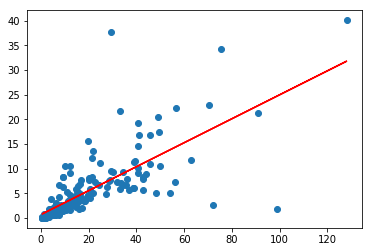

In [20]:
plt.scatter(x_dados, y_dados)
plt.plot(x_dados, y_predict, color='red')

___

<div id="ex5"></div>

### EXERCÍCIO 5 

Interprete os resultados acima. Você acha que os resíduos formam uma normal? Discuta a homocedasticidade do modelo (a variância dos erros é constante?).

[]

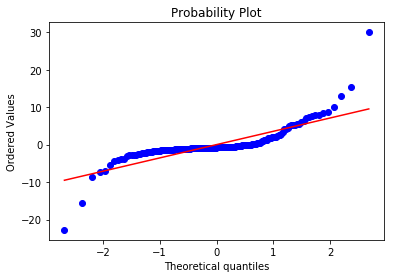

In [21]:
# ESCREVA SUA RESPOSTA AQUI
resid = results.resid

stats.probplot(resid, dist='norm', plot=plt)
plt.plot()

___

<div id="explica"></div>

# Explicação sobre resultados e suposições do modelo de regressão linear:

Os resumo dos resultados da regressão traz informações que nos permitem avaliar a qualidade do ajuste e a validade de:

* Validação das suposições (normalidade, homocedasticidade e independência dos resíduos)
* Teste de hipóteses dos coeficientes do modelo de regressão 

<div id="testet"></div>

### Teste t :  valor-*p*  da estatística t

Existente para cada coeficiente $\beta_i$ do modelo de regressão, testam as seguintes hipóteses:

$H_0: \beta_i = 0$

$H_1: \beta_i \neq 0$

Um valor-*p* (encontrado na coluna `P>|t|`) baixo permite **rejeitar** a hipótese $H_0: \beta_i = 0$. No caso de um modelo de regressão simples, as hipóteses para o coeficiente $\beta_1$ dizem sobre a significância da regressão.

In [22]:
valorp_beta0 = results.pvalues['const']
valorp_beta1 = results.pvalues['2010_income']

print('Valor-p sob H0: beta0 = 0: {:.6f}'.format(valorp_beta0))
print('Valor-p sob H0: beta1 = 0: {:.6f}'.format(valorp_beta1))

Valor-p sob H0: beta0 = 0: 0.122661
Valor-p sob H0: beta1 = 0: 0.000000


<div id="r2"></div>

### Coeficiente de determinação $R^2$

É uma medida de quão bem uma regressão capta a variação presente nos dados, ou parafraseando, o quanto de variabilidade nos dados é explicada pelo modelo de regressão.

$$ R^2 = 1 - \frac{SS_E}{SS_T}$$

Para calcular esta fórmula precisamos das relações:

$$SQRes=SS_{E}=\sum\limits^{n}_{i=1}(y_i-\hat{y}_i)^2=\sum\limits_{i=1}^{n}\epsilon^2_{i}$$

$$SQT=SS_{T}=\sum\limits^{n}_{i=1}(y_i-\bar{y})^2$$

O valor de $R^2$ pode ser obtido na coluna `R-squared`.

<div id="r2adj"></div>

### $R^2$ ajustado

Penaliza preditores que não acrescentam poder preditivo significativo. Essa medida é útil em modelo de regressão múltipla.

$$R^2ajustado = R^2 - (1-R^2)\frac{P}{n-p-1}$$

em que $n$ é o número de dados e $p$ é o número de preditores (número de variáveis explicativas)

O valor de $R^2$ ajustado pode ser obtido na coluna `Adj. R-squared`.


<div id="f"></div>

### Estatística F

Testa as seguintes hipóteses:

$H_0: \beta_1 = \beta_2 = \ldots = \beta_p = 0$

$H_1: \beta_i \neq 0$ para no mínimo algum $i$, com $i=1,\ldots,n$ 

A rejeição da hipótese nula implica que no mínimo uma variável explicativa (regressora) contruibui significantemente para o modelo. Esse teste F é mais útil no caso de modelo de regressão múltipla.

O valor p dessa estatística pode ser obtido na coluna `Prob (F-statistic)`. Se ele for menor do que o nível de significância escolhido, rejeitamos $H_0$ em favor de $H_1$ (alguma variável explicativa contribui significativamente para o modelo).


<div id="omnibus"></div>

### Teste Omnibus

Para que o modelo obtido via regressão linear simples possa ser considerado para tomada de decisão é necessário que as [suposições do modelo](#suposicoes) sejam válidas. O teste Omnibus testa a normalidade dos resíduos ($\varepsilon_i$):

$H_0:$ a distribuição dos resíduos é normal

$H_1:$ a distribuição dos resíduos não é normal

O valor-p desse teste pode ser obtido em `Prob(Omnibus)`. Se `Prob(Omnibus)` for muito baixo, existe evidência de que os resíduos **não são** distribuídos normalmente, violando nesse caso a suposição do modelo de regressão. O **ideal** é que esse valor seja maior do que $\alpha$ (nível de significância), assim não rejeitamos $H_0$.


<div id="jb"></div>

### Teste Jarque-Bera

Outro teste de normalidade dos resíduos:

$H_0:$ a distribuição dos resíduos é normal

$H_1:$ a distribuição dos resíduos não é normal

O valor-p desse teste pode ser obtido em `Prob(JB)`. Se `Prob(JB)` for muito baixo, existe evidência de que os resíduos **não são** distribuídos normalmente, violando nesse caso a suposição do modelo de regressão. O **ideal** é que esse valor seja maior do que $\alpha$ (nível de significância), assim não rejeitamos $H_0$.

Consulte este [link](https://towardsdatascience.com/testing-for-normality-using-skewness-and-kurtosis-afd61be860) para mais detalhes sobre qual o propósito do teste JB para validar normalidade de dados.



<div id="dw"></div>

### Teste Durbin-Watson

Testa a autocorrelação dos resíduos. Uma das [suposições](#suposicoes) é que os resíduos são independentes entre si. Esse valor varia na faixa $[0,4]$:

* Um valor próximo de $2$ sugere que não há autocorrelação dos resíduos
* Um valor menor que $2$ sugere **correlação positiva** dois resíduos
* Um valor maior que $2$ sugere **correlação negativa** dois resíduos

O **ideal** é que o valor de `Durbin-Watson` seja próximo de 2.

___
<div id="uso"></div>

# Utilização dos resultados e validação das suposições do modelo:

<div id="ex6"></div>

### EXERCÍCIO 6 - Análise dos valores p

O que os valores-p da regressão dizem a respeito dos *betas?*

In [ ]:
# ESCREVA SUA RESPOSTA AQUI

___

<div id="ex7"></div>

### EXERCÍCIO 7 - Análise da estatística F

O que o valor da estatística F diz sobre a qualidade da regressão? 

Diga qual hipótese nula e alternativa $Prob(F)$ avalia.

In [ ]:
# ESCREVA SUA RESPOSTA AQUI

___

<div id="ex8"></div>

### EXERCÍCIO 8 - Análise do $R^2$

O que o valor de $R^2$ obtido diz sobre o poder explicativo da regressão obtida via OLS?

In [ ]:
# ESCREVA SUA RESPOSTA AQUI

___

<div id="ex9"></div>

### EXERCÍCIO 9 - Análise de normalidade do resíduo

O que os testes *Omnibus* e *Jarque-Bera* dizem a respeito da normalidade do resíduo? 

In [ ]:
# ESCREVA SUA RESPOSTA AQUI

___

<div id="ex10"></div>

### EXERCÍCIO 10 - Análise de homocedasticidade

Verifique visualmente se a hipótese de homocedasticidade é válida.

In [ ]:
# ESCREVA SUA RESPOSTA AQUI